In [2]:
import numpy as np
import pandas as pd
import napari

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from utils import iss_legend

## Load color files

In [3]:
cell_color = pd.read_csv('./utils/cell_color.csv')
gene_color = pd.read_csv('./utils/gene_color_v2.csv')

## Napari

In [4]:
viewer = napari.Viewer()

In [5]:
# Add legend
iss_legend.add_legend(viewer, genes=gene_color, cells=cell_color, celltype=True, gene=True)

## Load pciSeq data

In [5]:
pciSeq_reading  = {
    'converters': {
        'Genenames': pd.eval, 
        'CellGeneCount': pd.eval,
        'ClassName': pd.eval,
        'Prob': pd.eval,
        'sphere_scale': pd.eval,
        'sphere_rotation': pd.eval
    }
}

In [6]:
cells = pd.read_csv('../right_Hipp/pciSeq/cellData.csv', **pciSeq_reading)

In [7]:
cells.shape

(24761, 19)

In [8]:
for c in tqdm(cells.index): 
    
    bestProb = np.argsort(cells.loc[c, 'Prob'])[::-1][0]
    
    cells.loc[c, 'bestProb'] = cells.loc[c, 'Prob'][bestProb]
    cells.loc[c, 'topClass'] = cells.loc[c, 'ClassName'][bestProb]

  0%|          | 0/24761 [00:00<?, ?it/s]

## Check pciSeq data

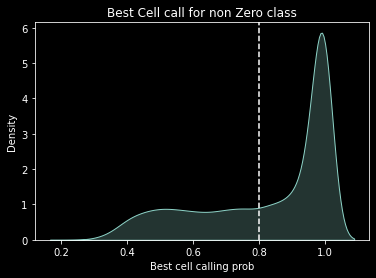

In [19]:
sns.kdeplot(cells[cells['topClass'] != 'Zero']['bestProb'], shade=True)
plt.xlabel('Best cell calling prob')

plt.title('Best Cell call for non Zero class')
plt.axvline(x=0.8, linestyle='dashed')
plt.show()

In [20]:
topClass_names,  topClass_counts = np.unique(cells['topClass'], return_counts=True)

In [21]:
sorted_names = topClass_names[np.argsort(topClass_counts)[::-1]]

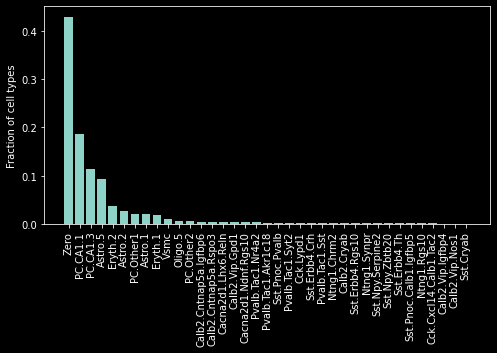

In [22]:
plt.figure(figsize=(8,4))

plt.bar(x=np.arange(len(sorted_names)), height=np.sort(topClass_counts)[::-1]/np.sum(topClass_counts))

plt.xticks(ticks=np.arange(len(sorted_names)), labels=sorted_names, rotation=90)
plt.ylabel('Fraction of cell types')

plt.show()

In [23]:
for c in tqdm(cells.index): 
    
    cells.loc[c, 'n_reads'] = np.sum(cells.loc[c, 'CellGeneCount'])

  0%|          | 0/24761 [00:00<?, ?it/s]

In [24]:
non_zero_n = cells[cells['topClass'] != 'Zero'].shape[0]

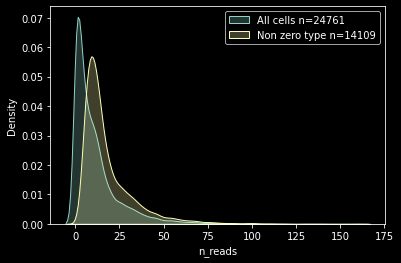

In [25]:
sns.kdeplot(cells['n_reads'], shade=True, label=f'All cells n={cells.shape[0]}')
sns.kdeplot(cells[cells['topClass'] != 'Zero']['n_reads'], shade=True, label=f'Non zero type n={non_zero_n}')

plt.legend()
plt.show()

## Visualize data

In [9]:
color_dict = dict()

for c in cell_color.index:
    
    color_dict[cell_color.loc[c, 'className']] = cell_color.loc[c, 'color']

In [10]:
cells['color'] = cells['topClass'].map(color_dict)

In [11]:
coords = np.stack((cells.Z, cells.Y, cells.X), axis=-1)

In [55]:
viewer.add_points(coords, 
                  face_color=list(cells.color),
                 edge_color='gray', edge_width=1, size=20)

<Points layer 'coords' at 0x16bc578e0>

In [12]:
viewer.add_points(coords[cells['topClass'] != 'Zero'], 
                  face_color=list(cells.color[cells['topClass'] != 'Zero']),
                 edge_color='gray', edge_width=1, size=20, name='SelectedTypes', opacity=.7)

<Points layer 'SelectedTypes' at 0x10d8baaf0>

## Load spot coordinates

In [13]:
# Load spots
all_spots = pd.read_csv('../right_Hipp/pciSeq/geneData.csv')

In [14]:
# Discard spots with only the 0 neighbour
spots = all_spots[all_spots['neighbour'] != 0]

In [15]:
coords_spots = np.stack((spots.z, spots.y, spots.x), axis=-1)

In [39]:
# Add all points as white dots

viewer.add_points(coords_spots,  name='GeneSpots',
                  face_color='w', size=4)

<Points layer 'GeneSpots' at 0x16baa4f10>

In [16]:
gene_color.head()

,Unnamed: 0,GeneNames,ColorR,ColorG,ColorB,Symbols,napari_symbol,mpl_symbol
0,0,Snca,0.0,0.0,1.0,+,cross,+
1,1,Cplx2,0.0,0.0,1.0,.,disc,.
2,2,Lhx6,0.0,0.0,1.0,s,square,s
3,3,Col25a1,0.0,0.0,1.0,^,triangle_up,^
4,4,Pnoc,0.0,0.0,1.0,>,vbar,_


In [17]:
gene_color_dict = dict()

for g in gene_color.index:
    
        gene_color_dict[gene_color.loc[g, 'GeneNames']] = (gene_color.loc[g, 'ColorR'], gene_color.loc[g, 'ColorG'], gene_color.loc[g, 'ColorB'])
    

In [18]:
# Add gene spots with ISS color code

for s in np.unique(gene_color['Symbols']):
    
    spots_to_plot = spots[spots['Gene'].isin(gene_color[gene_color['Symbols'] == s]['GeneNames'])]
    coords_to_plot = np.stack((spots_to_plot.z, spots_to_plot.y, spots_to_plot.x), axis=-1)
    spotcolor_to_plot = [gene_color_dict[i] for i in spots_to_plot['Gene']]
    
    symb_to_plot = np.unique(gene_color[gene_color['Symbols'] == s]['napari_symbol'])[0]
    
    viewer.add_points(coords_to_plot, face_color=spotcolor_to_plot, symbol=symb_to_plot, name=f'GeneSpots_Symbol_{s}', size=4)

In [41]:
target_gene = 'Sst'

viewer.add_points(coords_spots[spots['Gene'] == target_gene],  name=target_gene,
                  face_color=list(gene_color_dict[target_gene]), size=8)

<Points layer 'Sst' at 0x169049d60>

In [38]:
target_group = ['Slc17a8', 'Kctd12', 'Nov', 'Rgs10', 'Sema3c', 'Trp53i11', 'Cck', 'Cnr1', 'Sncg']

viewer.add_points(coords_spots[spots['Gene'].isin(target_group)],  
                  name='Red genes', face_color='r', size=8)

<Points layer 'Red genes' at 0x16984e4f0>

## Create animation for illustration

In [1]:
from napari_animation import Animation

In [36]:
anim = Animation(viewer)

In [45]:
anim.capture_keyframe()

In [49]:
anim.animate('demo.mov', canvas_only=True, quality=9, fps=15)

  0%|          | 0/121 [00:00<?, ?it/s]

Rendering frames...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2780, 1970) to (2784, 1984) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
100%|██████████| 121/121 [00:28<00:00,  4.20it/s]
